In [2]:
import numpy as np

#dataset_name = 'data_set' + letter + '.dat'"
data = np.loadtxt( 'data_setA.dat' )

In [3]:
# i be the row index which increased from bottom to top of each character.
# j be the column index which increased from left to right of the character.

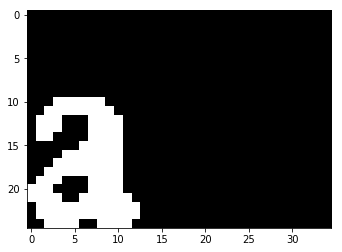

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
pattern = data[0:25]
pattern = np.flipud(pattern)
# Matplotlib imshow to mapping the 0 and 1 into black and white pattern in the image, respectively.
plt.imshow(pattern, cmap='gray', interpolation='nearest')


In [8]:
def index_title(printing=False):
    characters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
    indexes = []
    for char in characters:
        for i in range(1, 10+1):
            index = char + str(i)
            indexes.append(index)
        if printing==True:
            indexes.append('mean(' + char +')')
            indexes.append('var(' + char + ')')

    #print(indexes)
    row_names = np.array(indexes)
    row_names = pd.DataFrame(row_names)
    return characters, list(row_names[0])

In [9]:
import math
import numpy as np
import pandas as pd


I = [i for i in range(1,25+1)] # An array containing indexes in one of column
J = [i for i in range(1,35+1)] # An array containing indexes in one of row
#print(col, row)

def centroid(init, last, data):
    pattern = data[init:last]
    pattern = np.flipud(pattern)
    sum_sum_Xij = np.sum(pattern)
    sum_sum_Xij_times_i = sum(np.dot(pattern.T, I))
    sum_sum_Xij_times_j = sum(np.dot(pattern, J))
    
    imean = sum_sum_Xij_times_i/sum_sum_Xij
    jmean = sum_sum_Xij_times_j/sum_sum_Xij
    
    return pattern, imean, jmean

def mpq(pattern, imean, jmean, p, q):
    # The (p,q)th Central Moment of a pattern X is:
    i_part = (I-imean)**p
    i_part = np.reshape(i_part, (25,1))
    
    j_part = (J-jmean)**q
    j_part = np.reshape(j_part, (35, 1))
    
    step = pattern * i_part
    Mpq = np.sum(np.dot(step, j_part))
    #Mpq = step * j_part
    return float(Mpq)
'''
def mpq(pattern, imean, jmean, p, q):
    # The (p,q)th Central Moment of a pattern X is:
    total = 0
    for i in range(len(I)):
        for j in range(len(J)):
            total += (I[i] - imean)**p * (J[j] - jmean)**q * pattern[i][j]
    
    return total
'''

p = [0,0,1,2,0,1,2,3]
q = [0,2,1,0,3,2,1,0]

# Root mean square function.
def rms(df):
    df = np.array(df) **2
    rms = np.sqrt(np.mean(df))
    return rms

def all_rms(p, q, data):
    moments = [] # Moments of 100 samples
    overall_rms = []
    M = []
    mean = []
    var = []
    
    for index_p, index_q in zip(p,q):
        column_names = "M" + str(index_p) + str(index_q)
        M.append(column_names)
        
        central_moments = []

        init = 0
        last = 25
        counter = 0
    
        while last <= len(data):
            
            pattern, imean, jmean = centroid(init,last, data)
            Mpq = mpq(pattern, imean, jmean, index_p, index_q)
            central_moments.append(Mpq)
    
            # Put mean and var of the normalized central moments here
            
            # Direct answer for the variance in the set of means.
            #np.var already divides by N rather than N-1
            
            # Break point. It's time to stop.
            init += 25
            last += 25
            
        # 100 central_moments will be divided into 10
        
        RMS = rms(central_moments)
        moments.append(central_moments/RMS)
        
        overall_rms.append(RMS)
       
        # Clearing
        central_moments = []
        
    return M, pd.DataFrame(moments), overall_rms

In [10]:
def mean_and_var(Mpq, central_moments):
    k = 0
    l = 10
    all_means = []
    all_var = []
    central_moments.columns = Mpq
    while l <= 100:
        target = central_moments[k:l]
        means = []
        var = []
        for i in Mpq:
            element_mean = np.mean(target[i])
            # Direct answer for the variance in the set of means.
            element_var = np.var(target[i]) #np.var already divides by N rather than N-1
            means.append(element_mean)
            var.append(element_var)
        all_means.append(means)
        all_var.append(var)
        means = []
        var = []
        k += 10
        l += 10

    #print("mean", all_means)
    #print("var", all_var)

    mean_df = np.array(all_means)
    mean_df = pd.DataFrame(mean_df)

    var_df = np.array(all_var)
    var_df = pd.DataFrame(var_df)
    
    return mean_df, var_df

In [11]:
def indexing_nms(data):
    Mpq, moments, overall_rms = all_rms(p,q,data)
    normalized_cm = moments.transpose()

    mean_df, var_df = mean_and_var(Mpq, normalized_cm)
    mean_df.columns = Mpq
    var_df.columns = Mpq
    characters, indexes = index_title()

    title_add = []
    for i in range(len(mean_df)):
        normalized_cm = pd.concat([normalized_cm, mean_df.loc[[i]]])
        normalized_cm = pd.concat([normalized_cm, var_df.loc[[i]]])
        title_add.append('mean('+ characters[i]+')')
        title_add.append('var('+ characters[i]+')')

    overall_rms = pd.DataFrame(overall_rms).T
    overall_rms.columns = Mpq
    normalized_cm = pd.concat([normalized_cm, overall_rms.loc[[0]]])

    new_indexes = indexes + title_add + ['overall_rms']
    
    normalized_cm.index = new_indexes
    print('Indexing finished, generate normalized central moments')
    return normalized_cm, mean_df, var_df, overall_rms


In [12]:
def cov(X0):
    X = X0 - X0.mean(axis=0)
    N = X.shape[0]                # !!!# Divide by N
    covariance = np.dot(X.T, X)/N
    return covariance # !!!

In [13]:
def ncm_to_report(csv_file, normalized_data, mean_df, var_df, overall_rms):
    mean_df = mean_df
    var_df = var_df
    overall_rms = overall_rms
    letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
    for i in range(0,10):
        init=i * 10
        last = init+10
        
        ncm = pd.DataFrame(normalized_data[init:last])
        ncm.to_csv(csv_file, mode='a', float_format='%.3f')
        
        mean_target = mean_df.iloc[[i]]
        mean_target.index = ['mean(' + letters[i] + ')']
        mean_target.to_csv(csv_file, mode='a', header=None, float_format='%.3f')
        
        var_target = var_df.iloc[[i]]
        var_target.index = ['var(' + letters[i] + ')']
        var_target.to_csv(csv_file, mode='a', header=None, float_format='%.3f')
    
    overall_rms.index = ['Overall RMS']
    overall_rms.to_csv(csv_file, mode='a')
    
    line_break = pd.DataFrame([" "])
    line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    print("Ncm is written to %s" %csv_file)

In [14]:
def cov_inv_to_report(csv_file, normalized_data, dataset_name):
    from numpy.linalg import inv
    letters = ['a', 'c', 'e', 'm', 'n', 'o', 'r', 's', 'x', 'z']
    line_break = pd.DataFrame([" "])
    # To name the index as Inverse-Cov-Dataset-nth or Cov-Dataset-nth
    def index_title(mode, dataset_name, letter):
        title = ''
        if mode == "inverse":
            title = 'Inverse-Cov-Dataset-' + dataset_name + '-'+ letter
        else:
            title = 'Cov-Dataset-' + dataset_name + '-' + letter
        the_title = [title] + [' ' for i in range(7)]
        return the_title
    
    saved_cov = np.zeros(8) 
    
    # Running through the Covariance
    for i in range(0,10):
        init=i * 10
        last = init+10
        cov_letter = cov(normalized_data[init:last])
        saved_cov = np.add(saved_cov,cov_letter)
        cov_a = pd.DataFrame(cov_letter)
        cov_a.index = index_title("cov", dataset_name, letters[i])
        cov_a.to_csv(csv_file, mode='a', header=None, float_format='%.5f')
   
        line_break.to_csv(csv_file, mode='a', header=None, index=None)
        
    # Running through the Inverse of the Covariance
    for i in range(0,10):
        init=i * 10
        last = init+10
        inv_letter = inv(cov(normalized_data[init:last]))
        inv_a = pd.DataFrame(inv_letter)
        inv_a.index = index_title("inverse", dataset_name, letters[i])
        inv_a.to_csv(csv_file, mode='a', header=None, float_format='%.5f')
        line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    average_cov = saved_cov/10
    average_cov_inversed = inv(average_cov)
    
    average_cov = pd.DataFrame(average_cov)
    average_cov.index = ['Cov-Dataset-'+dataset_name] + [' ' for i in range(7)]
    average_cov.to_csv(csv_file, mode='a', header=None, float_format='%.6f')
    
    line_break.to_csv(csv_file, mode='a', header=None, index=None)
    
    average_cov_inversed = pd.DataFrame(average_cov_inversed)
    average_cov_inversed.index = ['Inverse-Cov-Dataset-'+dataset_name] + [' ' for i in range(7)]
    average_cov_inversed.to_csv(csv_file, mode='a', header=None, float_format='%.6f')
    
    print('Covariance and its Inverse are written to %s!' % csv_file)

        


In [18]:
def all_reports(adding_suffix):
    list_datasets = ['A', 'B', 'C', 'D']

    for i in range(len(list_datasets)):
        letter = list_datasets[i]
        label = 'data_set' + letter
        dataset = label +'.dat'
        data = np.loadtxt(dataset)
        normalized_cm, mean_df, var_df, overall_rms = indexing_nms(data)

        label = label + adding_suffix
        ncm_to_report(label, normalized_cm, mean_df, var_df, overall_rms)

        cov_inv_to_report(label, normalized_cm, letter)  

In [19]:
print(all_reports('_revised_report.csv'))

Indexing finished, generate normalized central moments
Ncm is written to data_setA_revised_report.csv
Covariance and its Inverse are written to data_setA_revised_report.csv!
Indexing finished, generate normalized central moments
Ncm is written to data_setB_revised_report.csv
Covariance and its Inverse are written to data_setB_revised_report.csv!
Indexing finished, generate normalized central moments
Ncm is written to data_setC_revised_report.csv
Covariance and its Inverse are written to data_setC_revised_report.csv!
Indexing finished, generate normalized central moments
Ncm is written to data_setD_revised_report.csv
Covariance and its Inverse are written to data_setD_revised_report.csv!
None
